In [1]:
import os
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

cuda Tesla P100-PCIE-16GB


In [4]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [5]:
config = AttrDict()
config.data_path = '/content/drive/MyDrive/Implement/data'
config.save_path = '/content/drive/MyDrive/Implement/GAN/gen_img'
config.n_epoch = 100
config.batch_size = 64
config.learning_rate = 1e-4
config.b1 = 0.5
config.b2 = 0.999
config.img_shape = (1, 28, 28)
config.latent_size = 100

config.augmentation = transforms.Compose([
                        transforms.Resize((config.img_shape[1], config.img_shape[2])),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5], std=[0.5]) 
                      ])
config.denormalize = lambda x: x*0.5+0.5
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
train_dataset = datasets.MNIST(config.data_path,
                                   train = True,
                                   download = True,
                                   transform = config.augmentation
                                   )
train_loader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(config.latent_size, 128),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Linear(1024, int(np.prod(config.img_shape))),
            nn.Tanh() # Gray scale
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.reshape(img.shape[0], *config.img_shape)
        return img

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(config.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = img.reshape(img.shape[0], -1)
        validity = self.model(img)
        return validity

In [9]:
criterion = nn.BCELoss()

G = Generator().to(config.device)
D = Discriminator().to(config.device)

# 따로 학습하기 위해서 optm 구별
optimizer_g = torch.optim.Adam(G.parameters(), lr = config.learning_rate, betas = (config.b1, config.b2))
optimizer_d = torch.optim.Adam(D.parameters(), lr = config.learning_rate, betas = (config.b1, config.b2))

In [10]:
G.model

Sequential(
  (0): Linear(in_features=100, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Linear(in_features=256, out_features=512, bias=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Linear(in_features=512, out_features=1024, bias=True)
  (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Linear(in_features=1024, out_features=784, bias=True)
  (12): Tanh()
)

In [11]:
D.model

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2, inplace=True)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [15]:
g_loss_list = []
d_loss_list = []
for epoch in tqdm(range(config.n_epoch)):
    for i, (real_img, _) in enumerate(train_loader):
        real_img = real_img.to(config.device) # b, 1, 28, 28
        valid_label = torch.ones((real_img.shape[0], 1), device = config.device, dtype = torch.float32) # b, 1
        fake_label = torch.zeros((real_img.shape[0], 1), device = config.device, dtype = torch.float32) # b, 1
        
        # Discriminator
        # b, 100 noise
        z = torch.randn((real_img.shape[0], config.latent_size), device = config.device, dtype = torch.float32)
        gen_img = G(z)

        real_loss = criterion(D(real_img), valid_label)
        # detach : generator는 학습 X
        fake_loss = criterion(D(gen_img.detach()), fake_label)
        d_loss = (real_loss + fake_loss) * 0.5

        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Generator
        z = torch.randn((real_img.shape[0], config.latent_size), device = config.device, dtype = torch.float32)
        gen_img = G(z)

        g_loss = criterion(D(gen_img), valid_label)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        if (i+1) == len(train_loader):
            g_loss_list.append(g_loss.item())
            d_loss_list.append(d_loss.item())
            print("Epoch [{}/{}]  Discriminator loss: {:.4f} Generator loss: {:.4f}".format(
                epoch+1, config.n_epoch, d_loss.item(), g_loss.item()))
    
    if epoch % 3 == 0:
        save_path = config.save_path + '/epoch_[{}].png'.format(epoch+1)
        gen_img = config.denormalize(gen_img)
        torchvision.utils.save_image(gen_img.data[:25], save_path, nrow = 5, normalize = True)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100]  Discriminator loss: 0.5597 Generator loss: 1.0608
Epoch [2/100]  Discriminator loss: 0.6745 Generator loss: 0.6096
Epoch [3/100]  Discriminator loss: 0.5905 Generator loss: 0.7366
Epoch [4/100]  Discriminator loss: 0.5887 Generator loss: 0.9501
Epoch [5/100]  Discriminator loss: 0.6211 Generator loss: 0.9994
Epoch [6/100]  Discriminator loss: 0.6694 Generator loss: 0.6530
Epoch [7/100]  Discriminator loss: 0.5604 Generator loss: 0.8278
Epoch [8/100]  Discriminator loss: 0.5750 Generator loss: 1.1371
Epoch [9/100]  Discriminator loss: 0.6731 Generator loss: 1.2693
Epoch [10/100]  Discriminator loss: 0.6107 Generator loss: 0.9409
Epoch [11/100]  Discriminator loss: 0.5947 Generator loss: 0.5366
Epoch [12/100]  Discriminator loss: 0.6387 Generator loss: 1.5817
Epoch [13/100]  Discriminator loss: 0.6527 Generator loss: 0.7474
Epoch [14/100]  Discriminator loss: 0.6519 Generator loss: 1.0256
Epoch [15/100]  Discriminator loss: 0.6114 Generator loss: 0.7567
Epoch [16/100]  Dis

KeyboardInterrupt: ignored

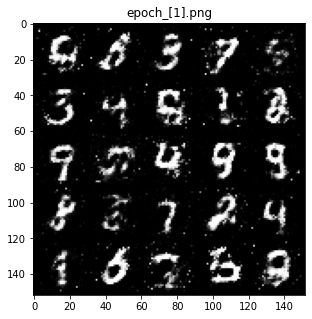

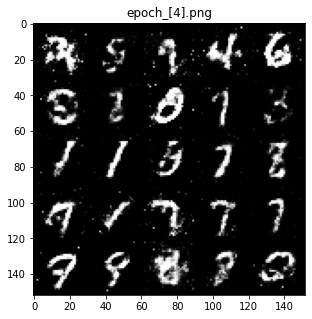

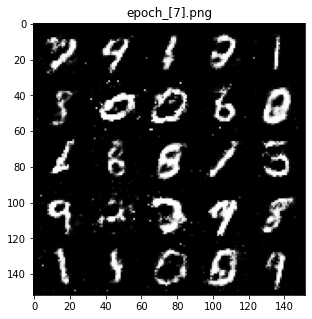

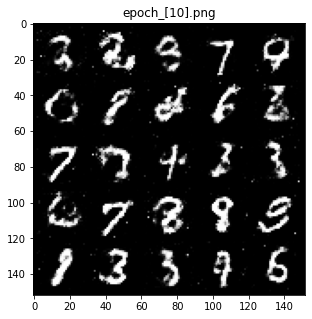

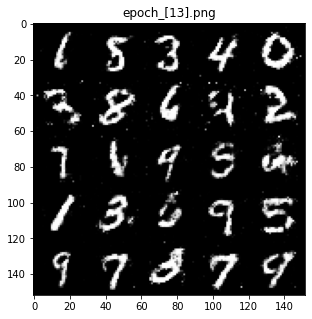

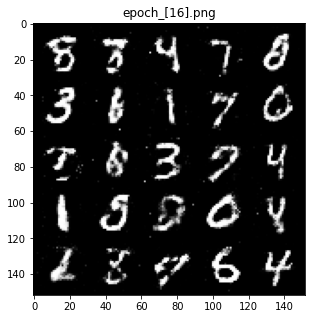

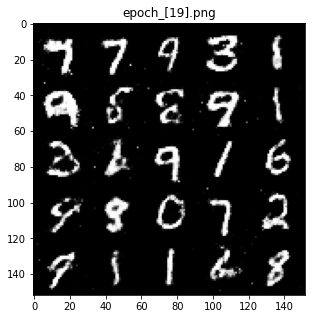

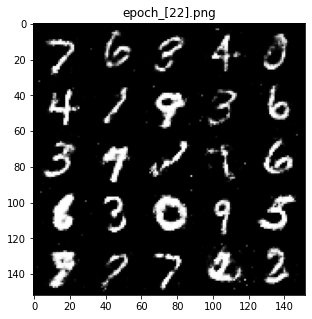

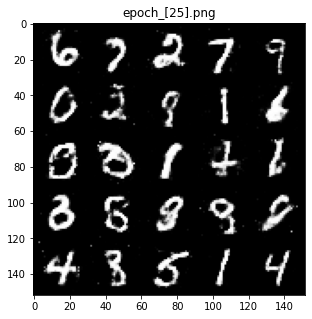

In [17]:
for image_path in os.listdir(config.save_path):
    plt.figure(figsize = (5,5))
    image = Image.open(config.save_path + '/' + image_path)
    plt.title(image_path)
    plt.imshow(image)
    plt.show()